# Project Water Resource Engineering

## Import librires

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, timedelta
from statsmodels.graphics.tsaplots import plot_acf

## Import data

In [99]:
flow1 = np.loadtxt("data/S1flow.txt", delimiter=',')
flow2 = np.loadtxt("data/S2flow.txt")

#CAN WE DELETE COMMENTED LINES?
#Why have 0 in the last values ????
#last_index_1 = 2129 
#last_index_2 =7239

#flow1 = flow1[:last_index_1]
#flow2 = flow2[:last_index_2]

s1 = pd.Series(flow1)
s2 = pd.Series(flow2)

## Define constant

In [100]:
#Hydropower Technical Data

Hg1 = 350
dHg1 = 0.05 * Hg1
Hn1 = Hg1-dHg1

Hg2 = 500 
dHg2 = 0.05 * Hg2
Hn2 = Hg2-dHg2

outages = 0.05
eff = 0.9

#Electricity Tarif

# Base scenario
peak_b = 6 #Us Sc/kWh
off_b = 3 

# High demand
peak_h = 10
off_h = 5

#Times
t_peak = 8 #h/d
t_off = 16

period = 20 # [y]

opex = 0.02 # capex/year

## Part 1

### Point a
Plot the last years of available data for the two stations S1 and S2 one vs the other to see if data are correlated (fit a polynomial function of adequate degree) and use the correlation structure to fill in the missing data. Neglect the noise

Pearson correlation: 0.99185


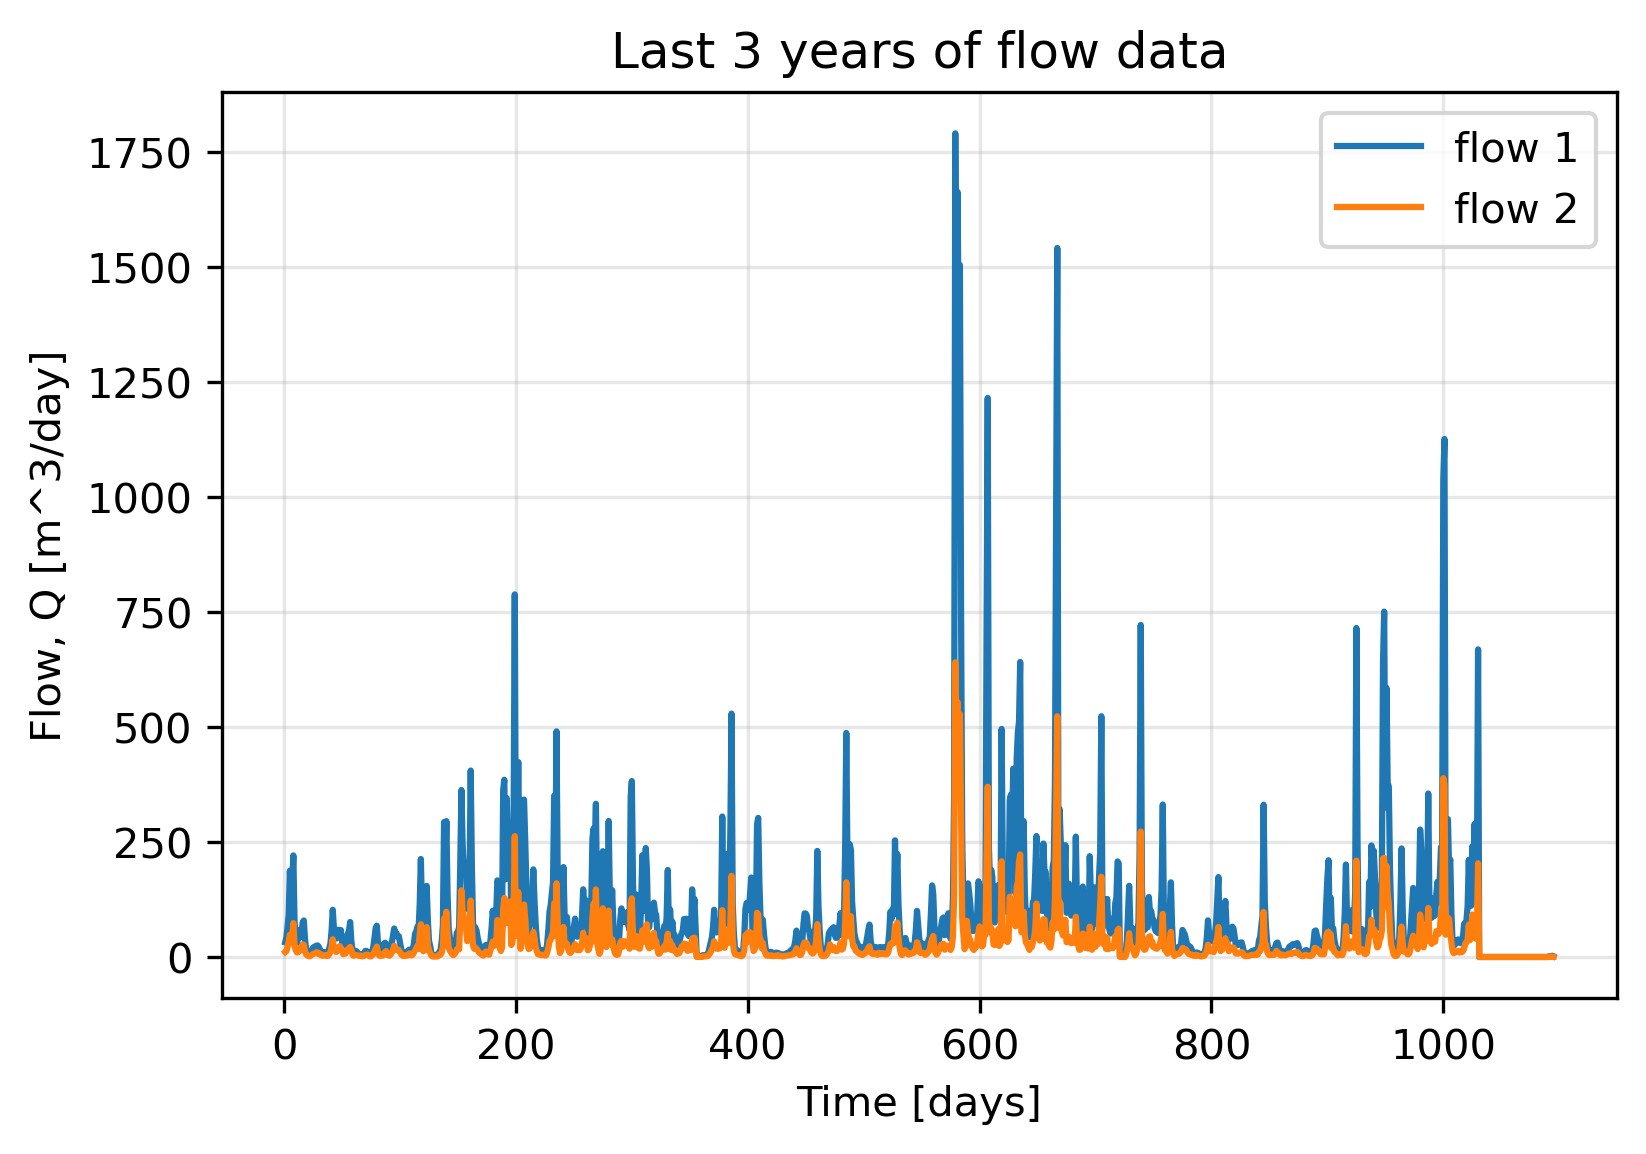

In [101]:
# Extract last years
years = 365 * 3
lasty_f1 = flow1[-years:] 
lasty_f2 = flow2[-years:]

x = np.linspace(1,years,years) 

# Calculate Pearson correlation
correlation = np.corrcoef(lasty_f1, lasty_f2)[0, 1]
print(f"Pearson correlation: {correlation:.5f}")

# Plot entire series and last years for both
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x,lasty_f1, label = "flow 1")
plt.plot(x,lasty_f2, label = "flow 2")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Last 3 years of flow data")
plt.xlabel("Time [days]")
plt.ylabel("Flow, Q [m^3/day]")
plt.show()

578
578


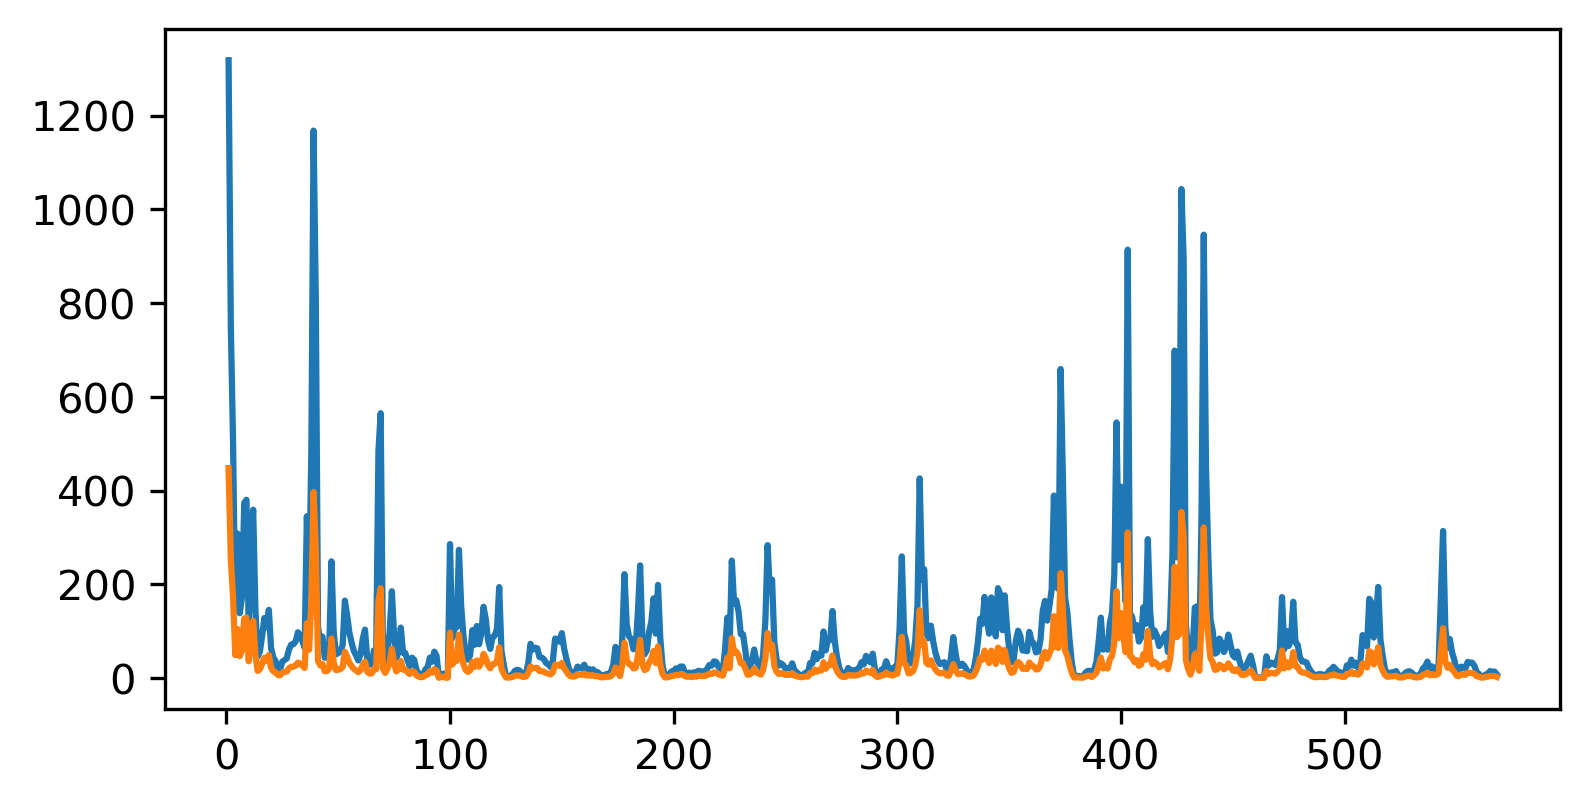

In [102]:
# Find relation between s1 and s2
# Step 1: id if lag between s1 and s2
ind_max1 = np.argmax(lasty_f1)
ind_max2 = np.argmax(lasty_f2)
print(ind_max1)
print(ind_max2)

#Step 2: fit a polynomial
n = 1 #degree
coef = np.polyfit(lasty_f2, lasty_f1, deg = n)
model = np.poly1d(coef) #test model

#Step 3: id missing values in s1 and replace by model
ind_missing_s1_Start = 266
ind_missing_s1_end = 834

ddata = 834-266

ind_s2 = len(s2)-(len(s1)-834)

s1[ind_missing_s1_Start:ind_missing_s1_end] = model(s2[ind_s2-ddata:ind_s2])

#Step 4 : Plot to visualise
x = np.arange(1,ddata+1)

plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(x,s1[ind_missing_s1_Start:ind_missing_s1_end])
plt.plot(x,s2[ind_s2-ddata:ind_s2])
plt.show()

### Point b
Use the same correlation relationship to prolonge the S1 series to the same length of the data serie in station 2. This will only be 20 years in total and we need to have at least 30 years. The swapping technique might be good, but we need to check if some temporal correlation affects the data before choosing the years to swap.

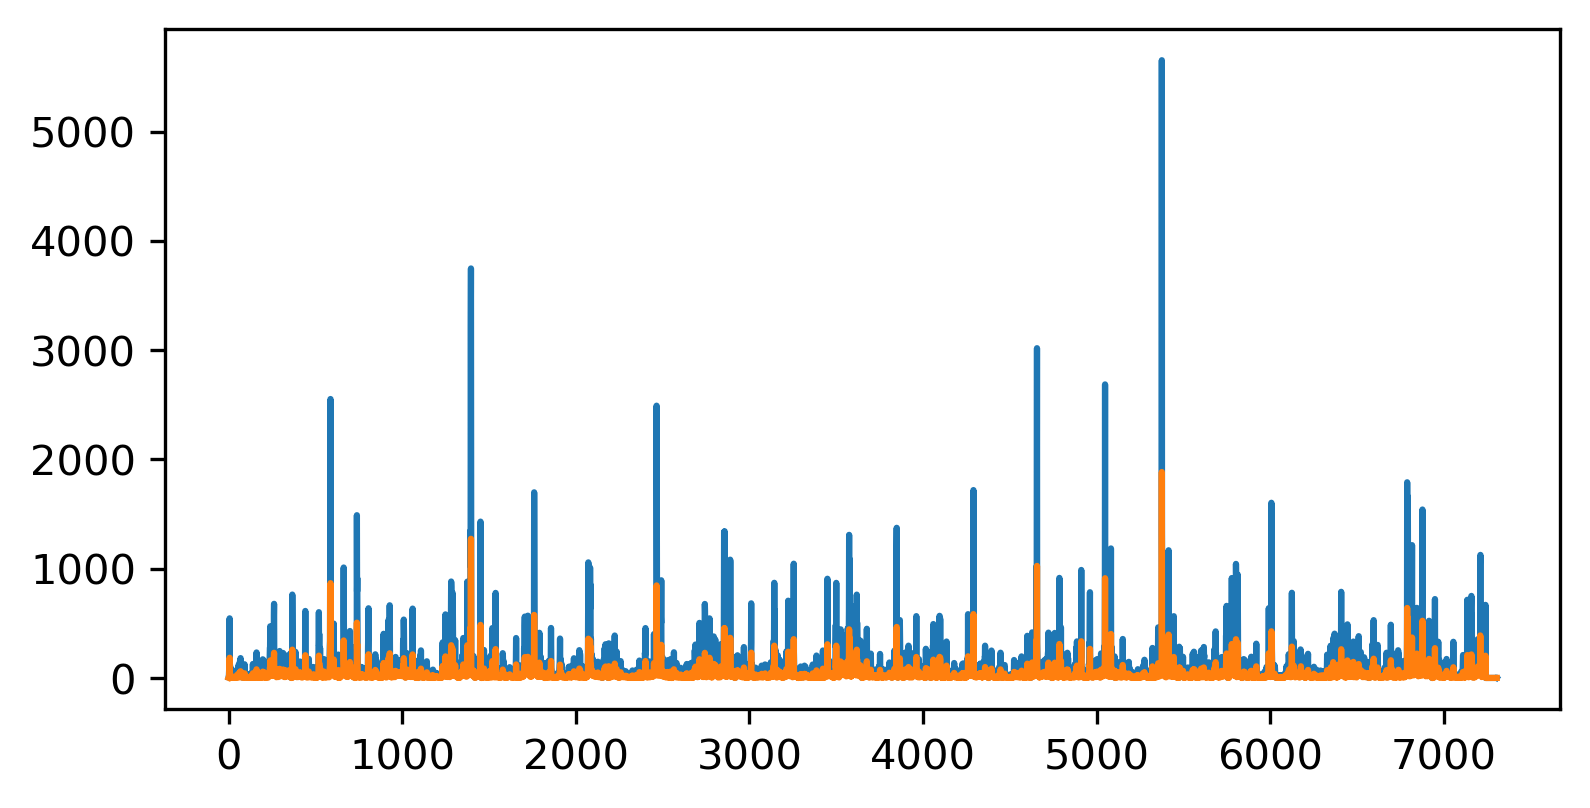

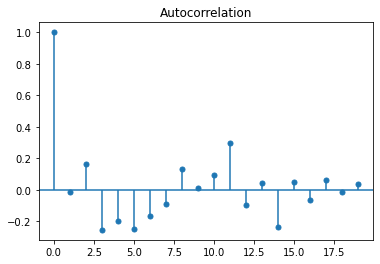

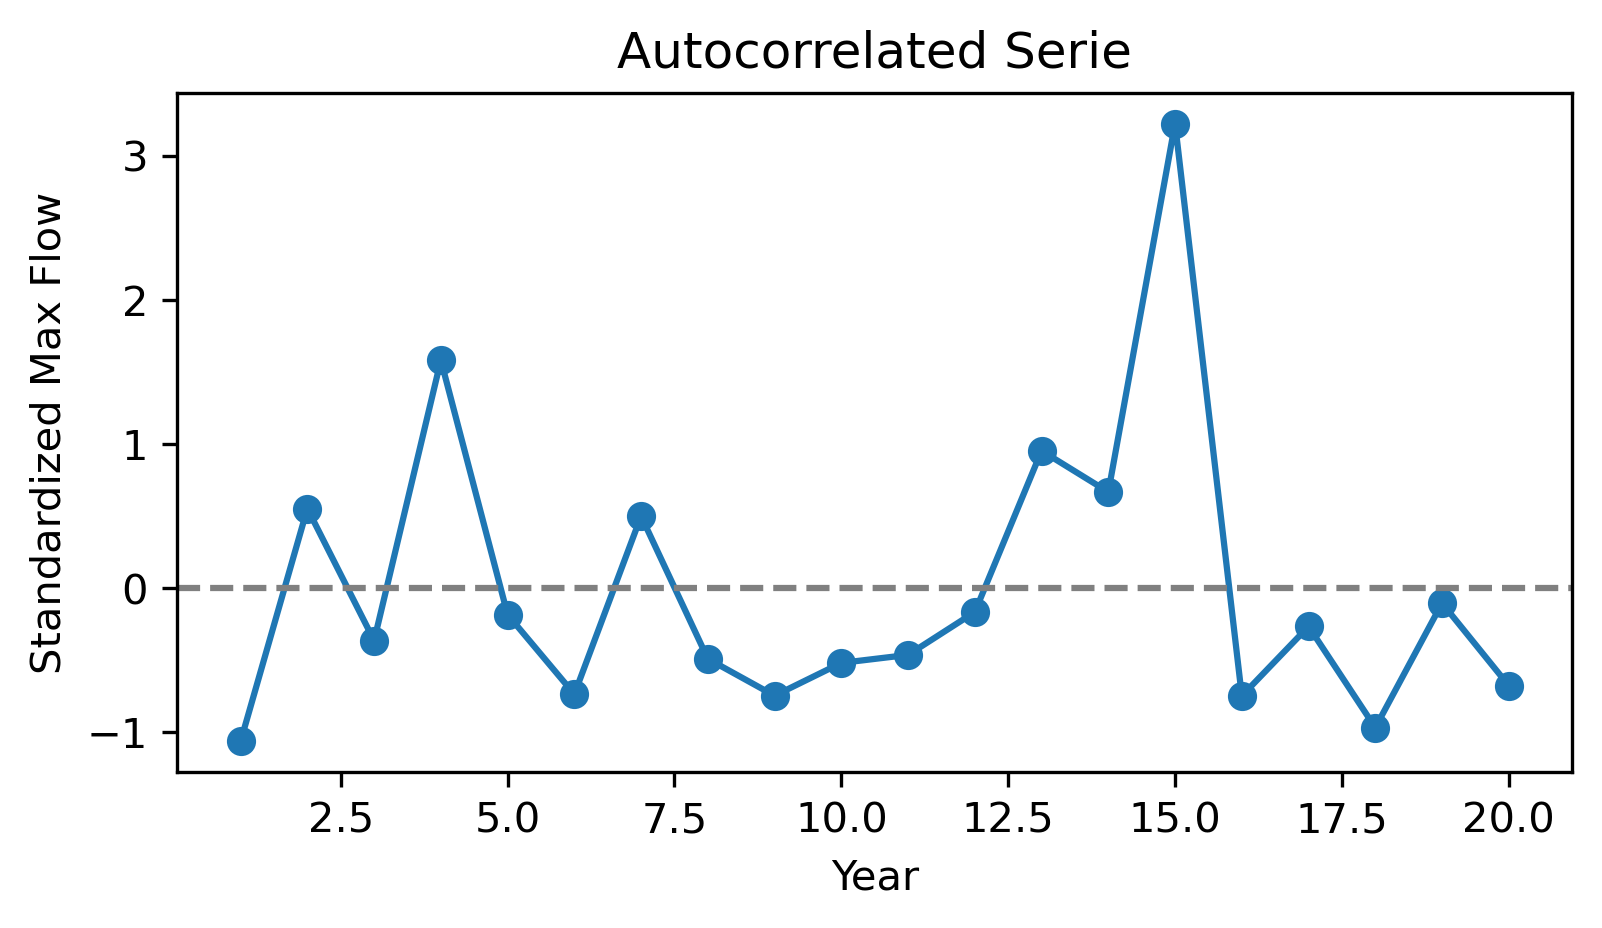

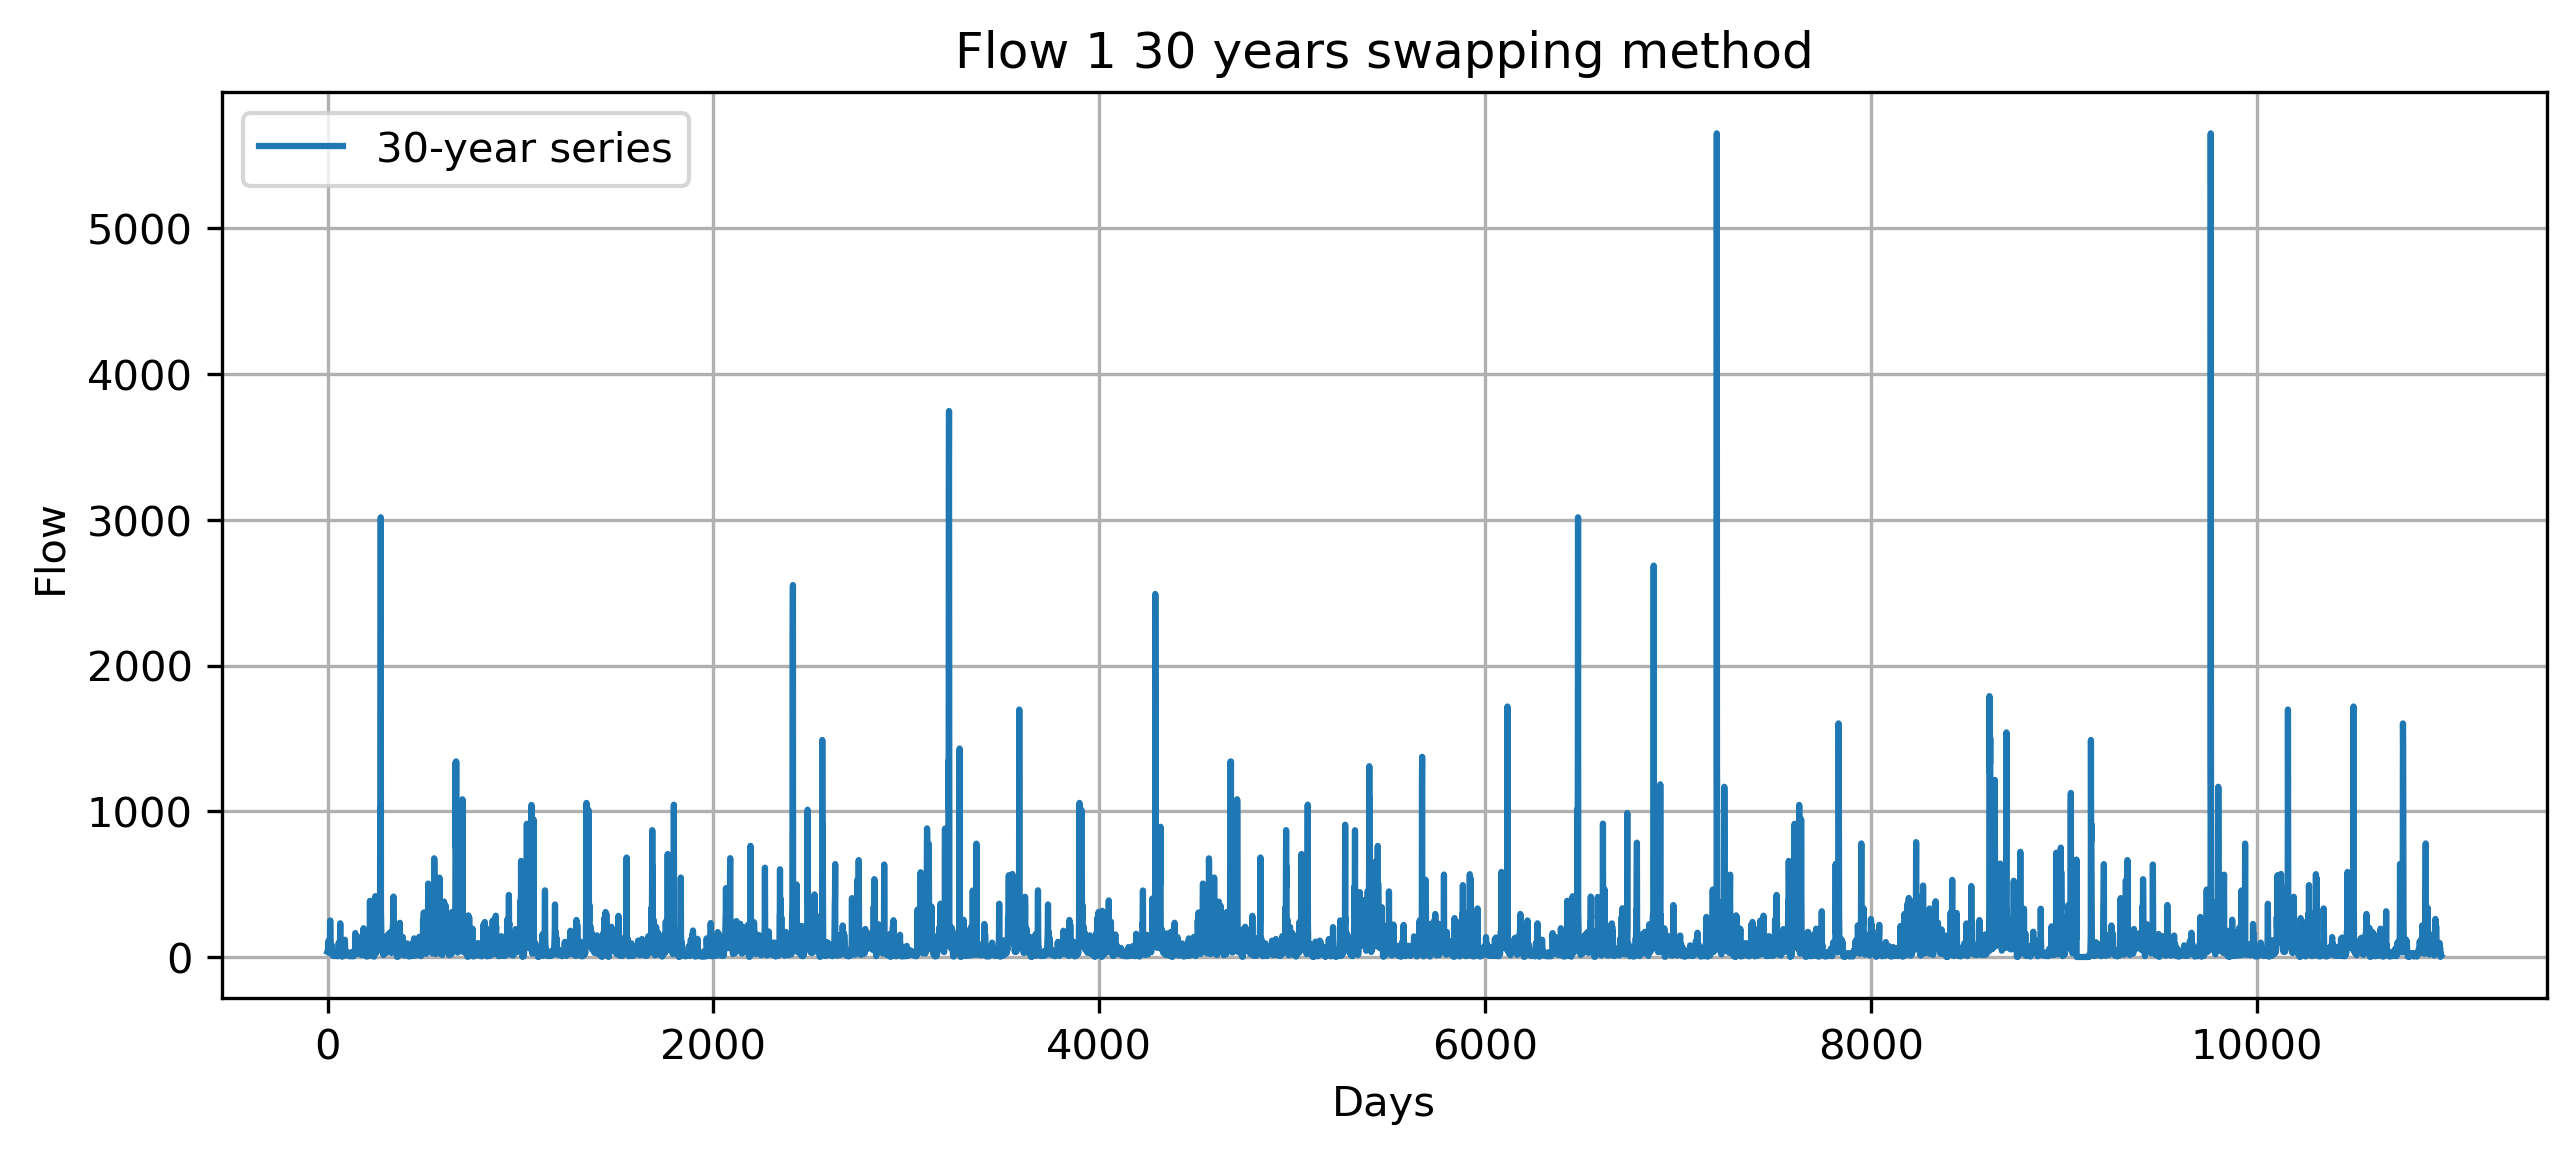

In [141]:
# Build S1 over 20 years
total_data_to_add = len(s2)-len(s1)

s1_20y = s2.copy()

s1_20y[:-len(s1)] = model(s2[:-len(s1)])
s1_20y[-len(s1):] = s1[:]


plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(s1_20y)
plt.plot(s2)
plt.show()

# Annual Max serie
y = 20 
max_s1 = [np.nanmax(s1_20y[i*365:(i+1)*365]) for i in range(y)]
max_s1 = np.array(max_s1)

# Autocorelated serie
plot_acf(max_s1, lags= 19, alpha= None)

#Years selection
mean_max = np.mean(max_s1)
std_max = np.std(max_s1)
z = (max_s1 - mean_max) / std_max

plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(range(1, y+1), z, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Autocorrelated Serie")
plt.xlabel("Year")
plt.ylabel("Standardized Max Flow")
plt.show()


#%% Swapping Coding

#Selecting which years -> kind of random, just trying to mix by following trend
#such as fluctuating above and below the mean and mixing the intensity 

swap_y_after = [2,14,4,11,16,19]

swap_y_before = [12,7,15,5,8]

before = []

after = []

for i in range(5):
    swap = s1_20y[swap_y_before[i] * 365 : (swap_y_before[i] + 1) * 365 ]     
    before = np.concatenate((before, swap)) 

    swap = s1_20y[swap_y_after[i] * 365 : (swap_y_after[i] + 1) * 365 ]     
    after = np.concatenate((after, swap)) 


    swap = s1_20y[swap_y[i] * 365 : (swap_y[i] + 1) * 365 ]  
    s1_30y = np.concatenate((s1_30y, swap))  

s1_30y = before
s1_30y = np.concatenate((s1_30y, s1_20y.copy())) 
s1_30y = np.concatenate((s1_30y, after)) 


# Plot the new 30-year time series
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(s1_30y, label='30-year series')
plt.xlabel('Days')
plt.ylabel('Flow')
plt.title('Flow 1 30 years swapping method')
plt.grid(True)
plt.legend()
plt.show()

[ 678.27756366 2552.39101851 1489.24436705 3747.03425862 1698.43022293
 1057.50296896 2491.38535257 1342.11168454 1045.50971924 1309.38919016
 1373.87430943 1719.03049652 3017.44107621 2686.02436701 5652.5114
 1043.63802082 1603.1         788.16933    1790.4715     1126.0011    ]


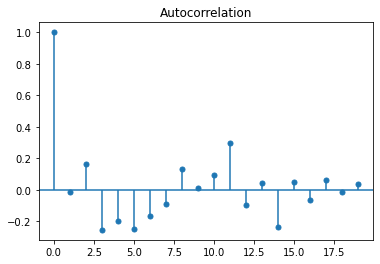

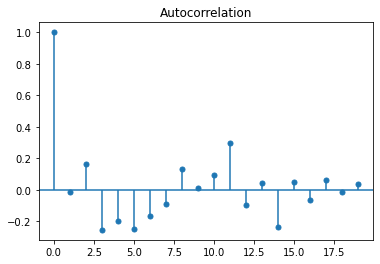

In [ ]:
print(max_s1)




### Point c
Build the flow duration curve of the 30 years dataset for reconstructed station one data and calculate the reference minimal flow for instream flow protection based on the Q 347 approach

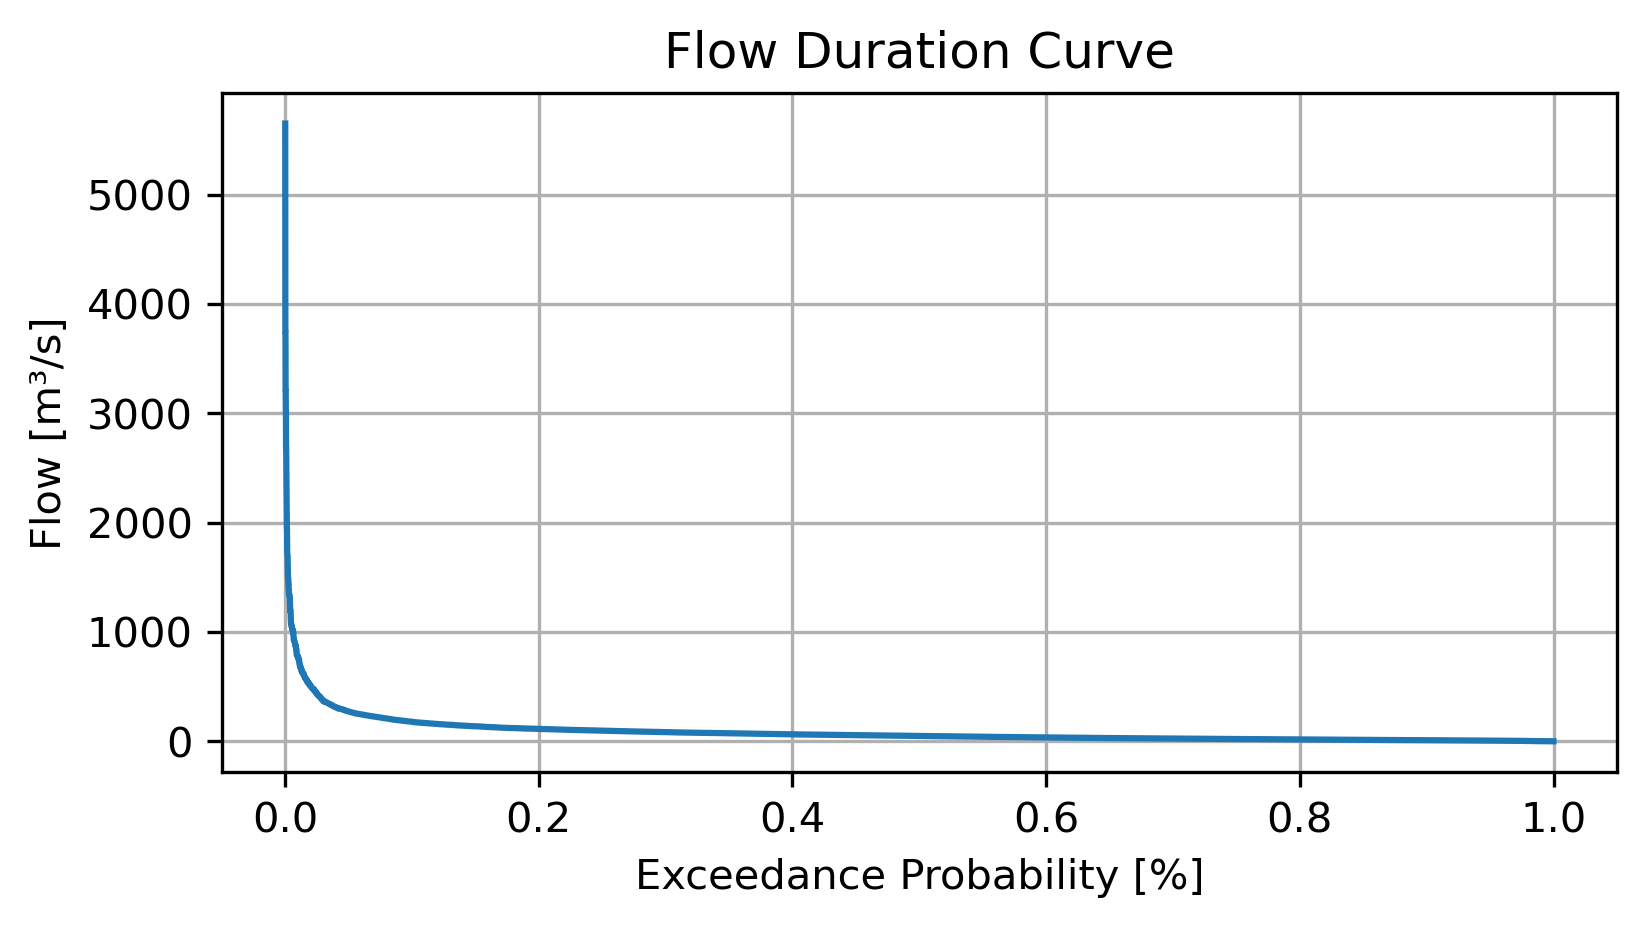

Q347 is :  6.083623541128314
Q347 prob. empirique:  0.949981745162468
Should be 0.95 otherwise need to make a curve fitting and find corresponding value for 0.95 !!!


In [104]:
# Weibull sorting
sortedQ = np.sort(s1_30y)[::-1]
rank = np.arange(1,len(sortedQ)+1)
prob = np.array([r / (len(sortedQ)+1) for r in rank]) 

plt.figure(figsize=(6, 3), dpi=300) 
plt.plot(prob, sortedQ)
plt.xlabel('Exceedance Probability [%]')
plt.ylabel('Flow [m³/s]')
plt.title('Flow Duration Curve')
plt.grid(True)
plt.show()

#Q347

ind = np.argmin(np.abs(prob - 0.95))# Find closest match index
print("Q347 is : ", sortedQ[ind])
print("Q347 prob. empirique: ",prob[ind])
print("Should be 0.95 otherwise need to make a curve fitting and find corresponding value for 0.95 !!!")

### Point d
Obtain the daily mean annual behaviour from data

In [105]:
y = 30
daily_mean_annual = [np.mean(s1_30y[i*365:(i+1)*365]) for i in range(y)]
print(daily_mean_annual)

[62.86511823180609, 110.24834881429257, 86.41264474763838, 124.0811582740804, 91.10400302280064, 71.93865456087406, 84.5170830014739, 106.25535344524583, 84.38338954498361, 108.6098181901752, 70.9083766424337, 73.7758007698132, 73.01530214602788, 99.20899891344992, 92.16754368071796, 88.91706644962261, 69.33308647958349, 81.31311676986303, 127.61201916958906, 75.38012201041096, 106.25624145690837, 124.08660067115694, 99.1991498519688, 86.39561803314339, 71.95411494899595, 84.39082246685143, 70.90030705151902, 73.02605313080991, 91.10676979932028, 81.31826860192875]


### Point e
Build the monthly mean annual time series, which will be used for the financial analysis

In [106]:
y = 30
month_days = [31,28,31,30,31,30,31,31,30,31,30,31]

monthly_mean = []

start = 0
for year in range(30):
    for i in month_days:
        month_s1 = s1_30y[start:start + i]
        monthly_mean.append(round(np.mean(month_s1),2))
        start += i

print(monthly_mean)

#!!! index 239 gives 0 -> related to year measured data where the last month was 0 Should we add it to the swap ??!!!


monthly_mean_overall = [] #monthly mean for all the studied years

for i in range(12):
    mean = 0
    for j in range(30):
        mean = mean + monthly_mean[i+j*12] 

    monthly_mean_overall.append(round(mean / 30, 2))
print()
print(monthly_mean_overall)

[57.4, 24.36, 44.36, 20.15, 28.15, 34.91, 60.37, 91.15, 151.25, 86.77, 86.62, 66.5, 139.56, 61.22, 84.89, 45.59, 27.05, 114.49, 53.32, 368.52, 68.12, 154.82, 108.29, 88.99, 156.16, 44.6, 75.97, 82.91, 35.31, 66.01, 129.02, 85.64, 90.79, 130.04, 106.26, 30.22, 67.26, 41.96, 26.71, 27.06, 77.68, 101.48, 255.27, 37.37, 136.55, 488.13, 77.46, 139.13, 59.53, 62.81, 105.86, 41.92, 39.07, 28.21, 46.67, 50.55, 276.73, 205.03, 123.29, 54.25, 36.51, 52.2, 68.65, 34.56, 35.25, 57.2, 75.61, 26.85, 265.44, 78.32, 30.29, 103.68, 77.82, 100.15, 42.97, 28.81, 21.92, 33.4, 60.83, 61.53, 113.82, 364.62, 66.53, 40.23, 65.4, 27.52, 32.92, 29.67, 78.68, 115.98, 129.32, 123.51, 104.26, 260.06, 182.39, 117.97, 90.32, 58.09, 56.83, 68.57, 32.63, 42.55, 41.47, 182.53, 72.27, 109.17, 163.53, 92.39, 32.81, 42.06, 28.67, 31.48, 37.28, 129.96, 58.48, 185.9, 163.93, 234.2, 206.44, 148.8, 79.6, 50.37, 29.59, 42.32, 36.26, 51.95, 149.19, 107.77, 97.69, 70.77, 92.37, 41.03, 58.21, 101.69, 118.1, 24.1, 40.42, 47.12, 26

### Point f
Use the reconstructed data for S1 to build two new series as the sequence of wet periods and the sequence of dry periods. To the purpose, use the annual mean as discriminant value for the wet years (above the mean, Aug Dec) and viceversa. We will use these series later to build the Pareto frontier of the system

In [107]:
wet = []

dry = []


for j in range(len(daily_mean_annual)):
    for i in range(365):
        if s1_30y[i+ 365*j]  > daily_mean_annual[j]:
            wet.append(s1_30y[i+365*j])
        else:
            dry.append(s1_30y[i+365*j])



## Part 2

In [ ]:
#Available Data
month = ["jan", "feb", "march", "april","may","june","july","Aug","sept","oct","nov","dec"]

temp_month = [24.72, 24.88, 25.71, 26.68, 27.02, 26.47, 25.94, 25.92, 25.9, 25.83, 25.65, 25.21] #[°C]

w_req_day = [3.81, 5.04, 4.62, 6.85, 6.17, 6.59, 6.78, 8.36, 6.96, 4.82, 4.50, 7.03] # [mm /°C/day]

kc = [0.7, 1.1, 1.1, 0.5, 0.7 , 1.1, 1.1, 0.5, 0.7, 1.1, 1.1, 0.5]

mean_cumul_rain = [137, 96, 93, 97, 189, 248, 291, 310, 281, 280, 230, 207] #[mm/month]

S = 370 # [ha] total irrigated area

number_day_month = 30 

Pour le ETO j'ai un doute sur comment le calculer !!!

In [109]:
# 1)

ET0 = [w_req_day[i] * 30 * temp_month[i]  for i in range(12)]  
print(ET0)

ETcrop = [ET0[i]*kc[i] for i in range(12)] # [mm/month]
print(ETcrop)


[2825.4959999999996, 3761.8559999999998, 3563.406, 5482.74, 5001.402, 5233.119, 5276.196000000001, 6500.736, 5407.92, 3735.0180000000005, 3462.75, 5316.789000000001]
[1977.8471999999997, 4138.0416000000005, 3919.7466000000004, 2741.37, 3500.9813999999997, 5756.4309, 5803.815600000002, 3250.368, 3785.544, 4108.519800000001, 3809.025, 2658.3945000000003]


In [110]:
# 2) Assuming no interception nor loss and stock is 0 at begining each month

Irrigation = [] #[mm/month]

for i in range(12):
    x = ETcrop[i] - mean_cumul_rain[i]
    if x < 0 :
        Irrigation.append(0)
    else:
        Irrigation.append(x) 

print(Irrigation)


net_water_need = [Irrigation[i] * S * 10 for i in range(12)] # volume in m^3 for each month
print(net_water_need)



[1840.8471999999997, 4042.0416000000005, 3826.7466000000004, 2644.37, 3311.9813999999997, 5508.4309, 5512.815600000002, 2940.368, 3504.544, 3828.519800000001, 3579.025, 2451.3945000000003]
[6811134.639999999, 14955553.920000002, 14158962.420000002, 9784169.0, 12254331.179999998, 20381194.330000002, 20397417.720000006, 10879361.6, 12966812.8, 14165523.260000004, 13242392.5, 9070159.65]


In [111]:
# 3)
eff_grav_irr = 0.35 # for sandy soil 0.3-0.4

gross_water_need = [net_water_need[i] / eff_grav_irr for i in range(12)]
print(gross_water_need)

[19460384.685714282, 42730154.05714287, 40454178.34285715, 27954768.571428575, 35012374.8, 58231983.80000001, 58278336.34285717, 31083890.285714287, 37048036.571428575, 40472923.60000001, 37835407.14285714, 25914741.85714286]


In [ ]:
# 4)

fict_flow = [round(gross_water_need[i] / (24*3600),2) for i in range(12)] #total Volume / 24h -> continuous flow for each month

print(fict_flow)


[225.24, 494.56, 468.22, 323.55, 405.24, 673.98, 674.52, 359.77, 428.8, 468.44, 437.91, 299.94]


Monthly Mean River Discharge: [72.63, 58.21, 51.4, 39.08, 47.69, 73.85, 87.49, 106.34, 141.94, 165.71, 132.35, 89.6]
Fictitious Irrigation Flow: [225.24, 494.56, 468.22, 323.55, 405.24, 673.98, 674.52, 359.77, 428.8, 468.44, 437.91, 299.94]


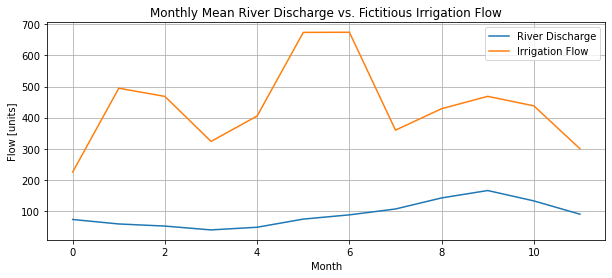

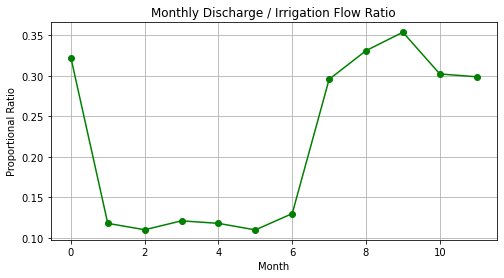

In [113]:
# 5) Seek for a proportional relationship between the monthly mean river discharges that you calculated in Project Week 1 and 
# the continous fictitious flowrate for irrigation needs. These proportions will be used later for successive project phases

# Step 1: Print and visualize both series
print("Monthly Mean River Discharge:", monthly_mean_overall)
print("Fictitious Irrigation Flow:", fict_flow)

plt.figure(figsize=(10, 4))
plt.plot(monthly_mean_overall, label="River Discharge")
plt.plot(fict_flow, label="Irrigation Flow")
plt.title("Monthly Mean River Discharge vs. Fictitious Irrigation Flow")
plt.xlabel("Month")
plt.ylabel("Flow [units]")
plt.legend()
plt.grid(True)
plt.show()

# Step 2: Check proportional relationship (avoid division by zero)
proportional = [
    monthly_mean_overall[i] / fict_flow[i] if fict_flow[i] != 0 else float('nan')
    for i in range(12)
]

# Step 3: Plot ratio
plt.figure(figsize=(8, 4))
plt.plot(proportional, marker='o', color='green')
plt.title("Monthly Discharge / Irrigation Flow Ratio")
plt.xlabel("Month")
plt.ylabel("Proportional Ratio")
plt.grid(True)
plt.show()